# PPO, R-PPO and VAE comparison

In [ ]:
from runner import run
from parameters import Parameters, VAEParameters, PPOParameters, RPPOParameters

params = Parameters(agent=PPOParameters(entropy_c2=0.025), n_episodes=4000)
for p in params.repeat(10):
    run(p)

params = Parameters(agent=RPPOParameters(entropy_c2=0.025), n_episodes=4000)
for p in params.repeat(10):
    run(p)

params = Parameters(agent=VAEParameters(), n_episodes=4000)
for p in params.repeat(10):
    run(p)

## Score over training time

(10, 4000)


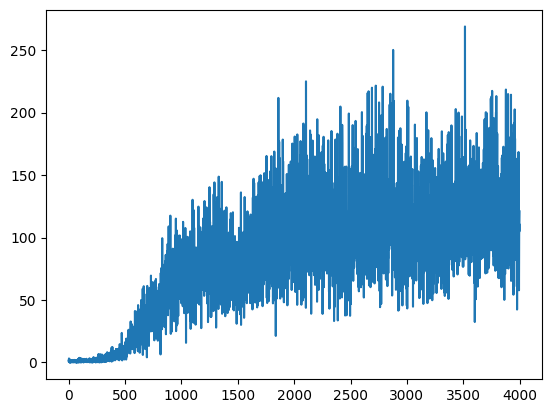

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from plots import Logs, Experiment

logdirs = {
    "ppo": "logs/ppo/2025-05-21T11-03-57.868549/",
    "vae": "logs/vae/2025-05-21T15-33-12.256548/"
}

def moving_average(x, w=10):
    return np.convolve(x, np.ones(w), 'valid') / w

for label, logdir in logdirs.items():
    logs = Experiment.from_directory(logdir)

    mean = np.mean(logs.amounts_over_time, axis=0)
    mean = moving_average(mean, 10)
    ci95 = np.percentile(logs.amounts_over_time, 95, axis=0) - np.percentile(logs.amounts_over_time, 5, axis=0)
    plt.plot(mean, label=label)
    plt.fill_between(range(len(mean)), mean - ci95, mean + ci95, alpha=0.2)
plt.xlabel("Episode")
plt.ylabel("Amount")

